(notebook_name)=
# 2.1 Building a Bayesian model for events
[2.1 Building a Bayesian model for events](https://www.bayesrulesbook.com/chapter-2.html#building-a-bayesian-model-for-events)

:::{post} March 24, 2022
:tags: python
:category: beginner
:author: Lode Nachtergaele
:::

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pyreadr
import requests
import seaborn as sns

In [3]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 1301
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

# Chapter 2 Bayes’ Rule

## [2.1 Building a Bayesian model for events](https://www.bayesrulesbook.com/chapter-2.html#building-a-bayesian-model-for-events)

In [4]:
result = pyreadr.read_r("data/fake_news.rda")

In [5]:
df = result["fake_news"]

In [6]:
df.head()

,title,text,url,authors,type,title_words,text_words,title_char,text_char,title_caps,...,disgust,fear,joy,sadness,surprise,trust,negative,positive,text_syllables,text_syllables_per_word
0,Clinton's Exploited Haiti Earthquake ‘to Steal...,0 SHARES Facebook Twitter\n\nBernard Sansaricq...,http://freedomdaily.com/former-haitian-senate-...,NaN,fake,17,219,110,1444,0,...,2.54,3.81,1.27,4.66,2.12,2.97,8.47,3.81,395,1.803653
1,Donald Trump Jr. Just Pinned A Tweet So Stupid...,\n\nPosted by Frank Wilkenmeyer on 19 Sep 2016...,http://winningdemocrats.com/donald-trump-jr-ju...,NaN,real,18,509,95,3016,0,...,1.90,1.90,1.71,1.33,1.14,4.17,4.74,4.93,845,1.660118
2,Michelle Obama NOT Leaving The White House – H...,Michelle Obama NOT Leaving The White House – H...,http://rightwingnews.com/top-news/michelle-oba...,Sierra Marlee,fake,16,494,96,2881,1,...,0.98,1.57,1.96,0.78,1.18,3.73,3.33,5.49,806,1.631579
3,Trump hits Clinton on Islamic State: ‘It is ti...,"“Crooked Hillary has been fighting ISIS, or wh...",http://politi.co/2cEsAnL,"Jack Shafer,Nolan D",real,11,268,60,1674,0,...,1.79,4.30,0.36,1.79,1.79,2.51,6.09,2.15,461,1.720149
4,Australia Voted To Ban Muslims And Liberals Ar...,When Donald Trump said that he wanted to ban M...,https://goo.gl/p7jFZG,Blair Patterson,fake,9,479,54,2813,0,...,0.41,0.82,1.23,0.82,0.82,2.46,2.66,4.30,761,1.588727


In [7]:
pd.concat(
    [
        df["type"].value_counts().rename("n"),
        df["type"].value_counts(normalize=True).rename("percent"),
    ],
    axis=1,
)

,n,percent
real,90,0.6
fake,60,0.4


In [8]:
pd.crosstab(df["title_has_excl"], df["type"], margins=True)

type,fake,real,All
title_has_excl,,,
False,44,88,132
True,16,2,18
All,60,90,150


In [9]:
article = pd.Series(["real", "fake"], dtype="category")

In [10]:
prior = pd.Series([0.6, 0.4])

In [11]:
df_sample = pd.DataFrame({"type": article, "weights": prior})

In [12]:
df_sample.sample(3, replace=True, random_state=1301, weights="weights")

,type,weights
0,real,0.6
1,fake,0.4
0,real,0.6


In [13]:
article_sim = df_sample.sample(10_000, replace=True, random_state=84735, weights="weights")

[Text(0.5, 1.0, 'FIGURE 2.2: A bar plot of the fake vs real status of 10,000 simulated articles.')]

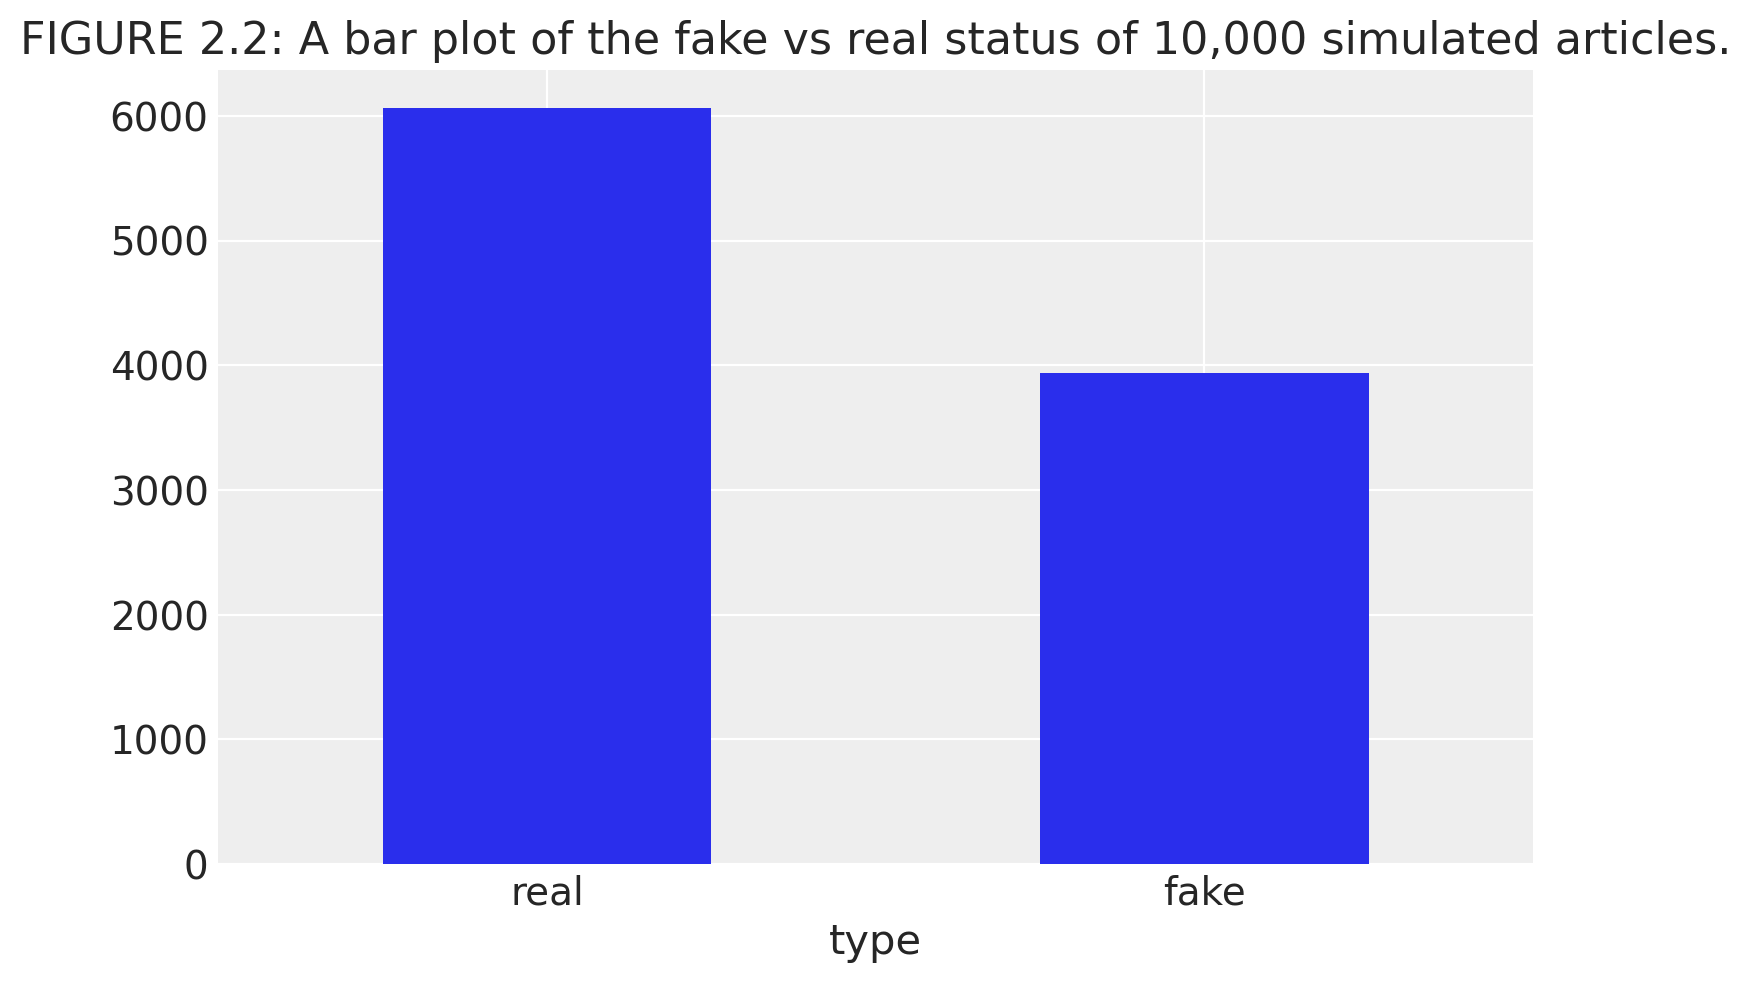

In [14]:
ax = article_sim["type"].value_counts().plot.bar(rot=0)
ax.set_xlabel("type")
ax.set(title="FIGURE 2.2: A bar plot of the fake vs real status of 10,000 simulated articles.");

In [15]:
article_sim["type"].value_counts()

real    6062
fake    3938
Name: type, dtype: int64

In [16]:
article_sim["data_model"] = article_sim["type"].map({"fake": 0.2667, "real": 0.0222})
article_sim.head()

,type,weights,data_model
0,real,0.6,0.0222
1,fake,0.4,0.2667
1,fake,0.4,0.2667
1,fake,0.4,0.2667
1,fake,0.4,0.2667


In [17]:
# The number of artices that are fake
N_fake = (article_sim["type"] == "fake").sum()
# The number of artices that are real
N_real = (article_sim["type"] == "real").sum()
article_sim.loc[article_sim["type"] == "fake", "usage"] = np.random.choice(
    ["no", "yes"], size=N_fake, replace=True, p=[1 - 0.2667, 0.2667]
)
article_sim.loc[article_sim["type"] == "real", "usage"] = np.random.choice(
    ["no", "yes"], size=N_real, replace=True, p=[1 - 0.0222, 0.0222]
)

In [18]:
pd.crosstab(article_sim["usage"], article_sim["type"], margins=True)

type,fake,real,All
usage,,,
no,2868,5921,8789
yes,1070,141,1211
All,3938,6062,10000


/tmp/ipykernel_91265/4205832381.py:10: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(top=0.15)


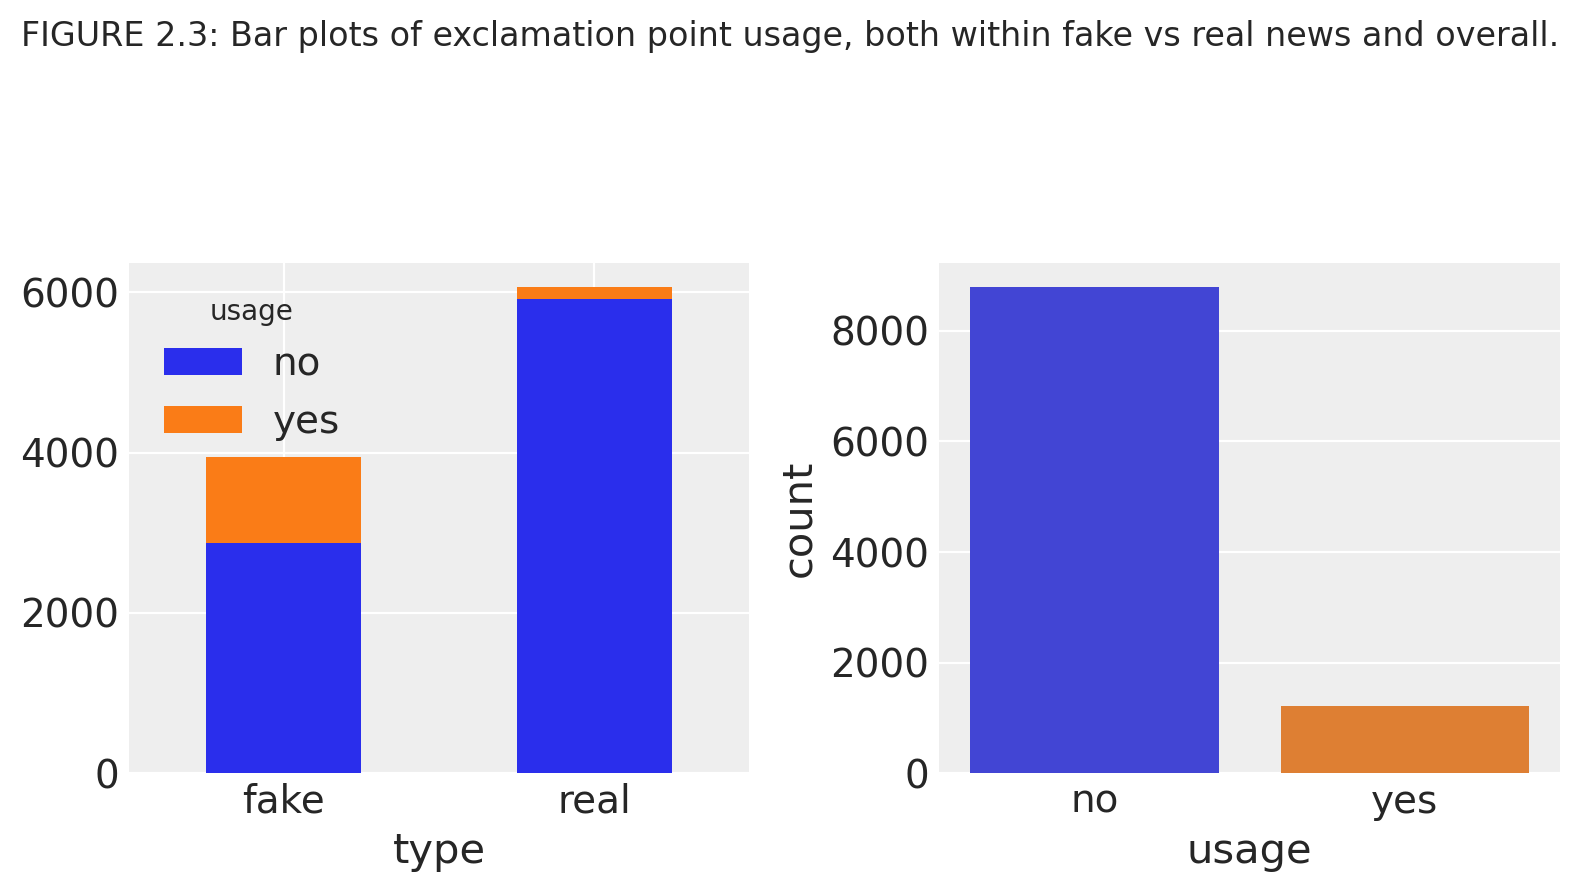

In [19]:
fix, ax = plt.subplots(1, 2, figsize=(8, 4.5))
pd.crosstab(article_sim["type"], article_sim["usage"]).plot(
    kind="bar", stacked=True, rot=0, ax=ax[0]
)
sns.countplot(x="usage", data=article_sim, ax=ax[1])
# article_sim['usage'].value_counts().plot.bar(rot=0, ax=ax[1]);
plt.suptitle(
    "FIGURE 2.3: Bar plots of exclamation point usage, both within fake vs real news and overall."
)
plt.subplots_adjust(top=0.15)
plt.tight_layout()

/home/canyon/miniconda3/envs/bayes_rules/lib/python3.10/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'FIGURE 2.4: Bar plots of real vs fake news, broken down by exclamation point usage.')

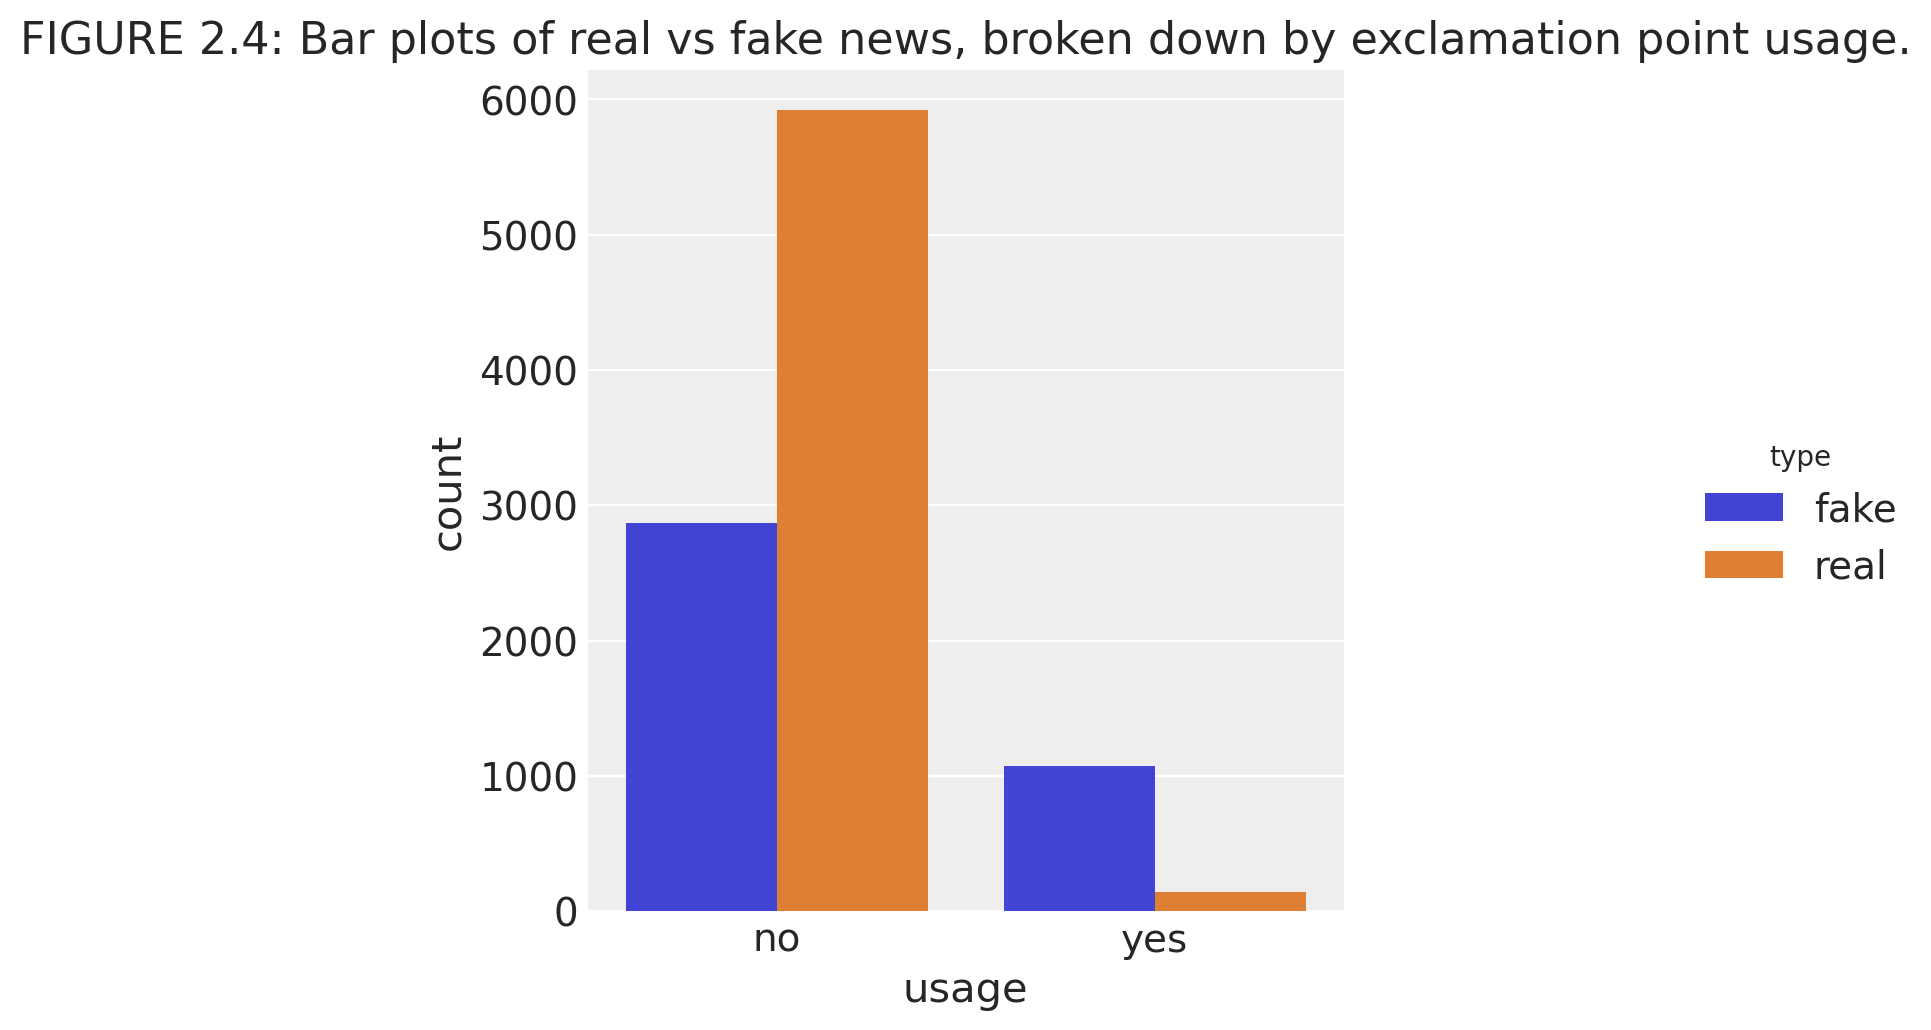

In [20]:
sns.catplot(x="usage", hue="type", data=article_sim, kind="count")
plt.title("FIGURE 2.4: Bar plots of real vs fake news, broken down by exclamation point usage.")

## [2.2 Example: Pop vs soda vs coke](https://www.bayesrulesbook.com/chapter-2.html#michelle-simple)

In [5]:
# Read the R data file pop_vs_soda.rda and display first lines


result = pyreadr.read_r("data/pop_vs_soda.rda")
pop_vs_soda = result["pop_vs_soda"]
pop_vs_soda.head()

,state,region,word_for_cola,pop
0,alabama,south,pop,True
1,alabama,south,pop,True
2,alabama,south,pop,True
3,alabama,south,pop,True
4,alabama,south,pop,True


In [23]:
# Table 2.5: Summarize pop use by region
pd.crosstab(pop_vs_soda["pop"], pop_vs_soda["region"], normalize="columns")

region,midwest,northeast,south,west
pop,,,,
False,0.355296,0.726603,0.920778,0.705721
True,0.644704,0.273397,0.079222,0.294279


## [Section 2.3.7 Posterior simulation](https://www.bayesrulesbook.com/chapter-2.html#chapter-2-simulation)

In [24]:
# Define possible win probabilities
chess = pd.Series([0.2, 0.5, 0.8], name="pi")
# Define the prior model
prior = pd.Series([0.10, 0.25, 0.65])

In [25]:
chess_sample = pd.DataFrame({"pi": chess, "weights": prior})

In [26]:
# Simulate 10000 values of pi from the prior
chess_sim = chess_sample.sample(10_000, replace=True, random_state=84735, weights="weights")
chess_sim.head()

,pi,weights
1,0.5,0.25
2,0.8,0.65
2,0.8,0.65
2,0.8,0.65
2,0.8,0.65


In [27]:
chess_sim["y"] = np.random.binomial(n=6, p=chess_sim["pi"], size=10_000)
chess_sim.head()

,pi,weights,y
1,0.5,0.25,3
2,0.8,0.65,5
2,0.8,0.65,6
2,0.8,0.65,6
2,0.8,0.65,6


In [28]:
# Summerize the prior
df_prior = pd.concat(
    [
        chess_sim["pi"].value_counts().rename("n"),
        chess_sim["pi"].value_counts(normalize=True).rename("percent"),
    ],
    axis=1,
)
df_prior.loc["Total", :] = df_prior.sum(axis=0)
df_prior

,n,percent
0.8,6468.0,0.6468
0.5,2495.0,0.2495
0.2,1037.0,0.1037
Total,10000.0,1.0000


/home/canyon/miniconda3/envs/bayes_rules/lib/python3.10/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, 'FIGURE 2.9: A bar plot of simulated win outcomes y under each possible win probability π.')

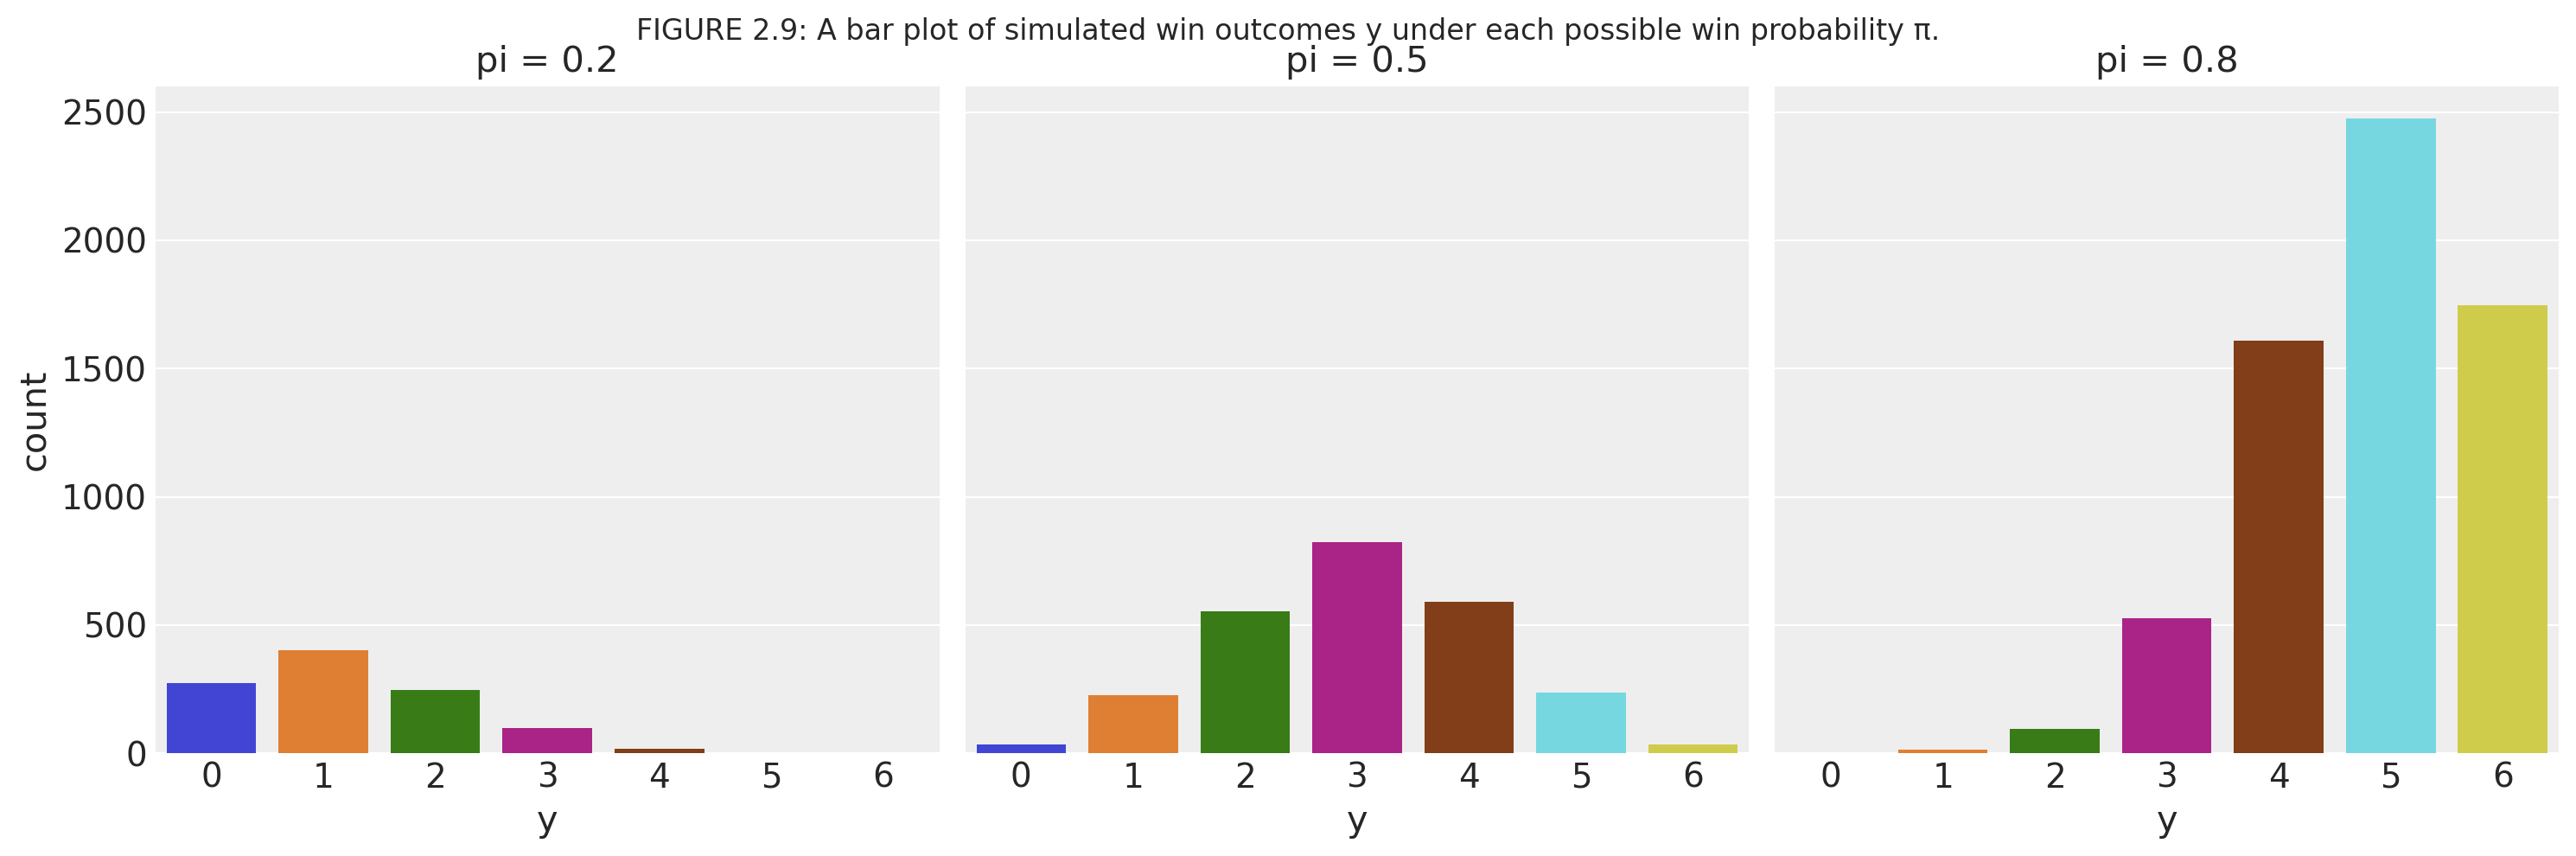

In [29]:
rp = sns.catplot(x="y", col="pi", data=chess_sim, kind="count")
rp.fig.subplots_adjust(top=0.9)  # adjust the Figure in rp
rp.fig.suptitle(
    "FIGURE 2.9: A bar plot of simulated win outcomes y under each possible win probability π."
)

In [30]:
win_one = chess_sim[chess_sim["y"] == 1]

In [31]:
# Summarize the posterior approximation
# The combined 10,000 simulated pi values closely approximate the prior model f(π)(Table 2.7):
df_posterior = pd.concat(
    [
        win_one["pi"].value_counts().rename("n"),
        win_one["pi"].value_counts(normalize=True).rename("percent"),
    ],
    axis=1,
)
df_posterior.loc["Total", :] = df_posterior.sum(axis=0)
df_posterior

,n,percent
0.2,403.0,0.626750
0.5,227.0,0.353033
0.8,13.0,0.020218
Total,643.0,1.000000


Text(0.5, 1.0, 'FIGURE 2.10: A bar plot of 10,000 simulated π values which approximates the posterior model.')

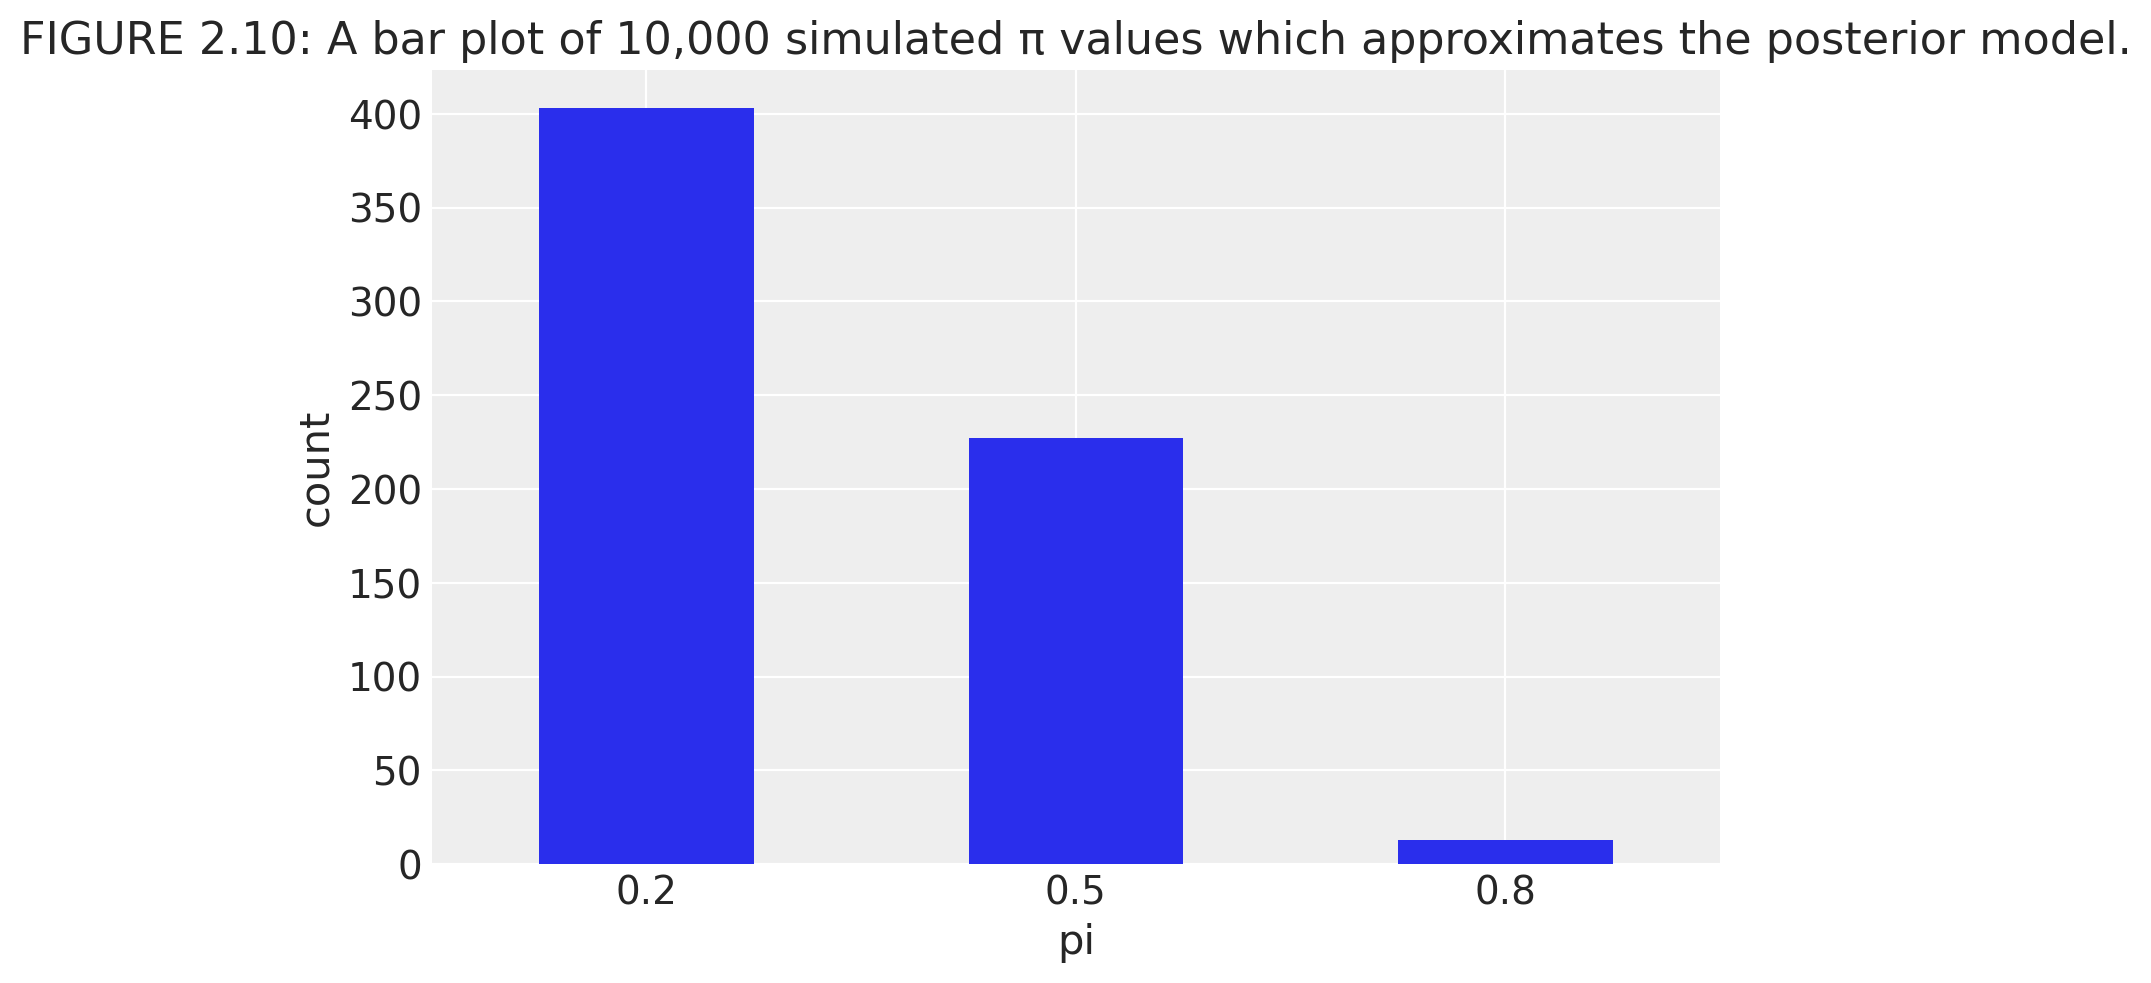

In [32]:
ax = df_posterior.iloc[:-1]["n"].plot.bar(rot=0)
ax.set_xlabel("pi")
ax.set_ylabel("count")
ax.set_title(
    "FIGURE 2.10: A bar plot of 10,000 simulated π values which approximates the posterior model."
)

In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Sun Mar 27 2022

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.1.1

matplotlib: 3.5.1
seaborn   : 0.11.2
pandas    : 1.4.1
requests  : 2.27.1
numpy     : 1.22.3
pyreadr   : 0.4.4
pymc      : 4.0.0b5
arviz     : 0.12.0

Watermark: 2.3.0



:::{include} ../page_footer.md
:::